In [1]:
import pandas as pd
import torch
from typing import NamedTuple, Dict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from histaug.utils import load_features
from histaug.metrics import compute_dists, DISTANCE_METRICS
from histaug.feature_extractors import FEATURE_EXTRACTORS
from histaug.utils.display import RENAME_AUGMENTATIONS

In [2]:
models = FEATURE_EXTRACTORS.keys()
# models = ["ctranspath", "swin", "resnet50"]
# models = ["ctranspath", "swin", "owkin", "vit"]
# models = ["retccl", "resnet50"]
# models = ["dino_p16", "vits", "ctranspath", "swin"]
models = ["dino_p16", "vits"]

N = 10000

features_by_model = {
    model: load_features(f"/data/histaug/features/kather100k/{model}.zarr", n=N, remove_classes=("BACK",))
    for model in tqdm(models)
}

100%|██████████| 2/2 [00:13<00:00,  6.67s/it]


In [5]:
metric = "cosine"
# metric = "euclidean"
# metric = "manhattan"
# metric = "mahalanobis"


class LoadedFeaturesAndDists(NamedTuple):
    feats: np.ndarray
    feats_augs: Dict[str, np.ndarray]
    labels: np.ndarray
    files: np.ndarray
    dists: pd.DataFrame


features_and_dists_by_model = {
    model: LoadedFeaturesAndDists(
        feats=f.feats,
        feats_augs=f.feats_augs,
        labels=f.labels,
        files=f.files,
        dists=compute_dists(f.feats, f.feats_augs, metric=metric),
    )
    for model, f in tqdm(features_by_model.items())
}

100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


In [15]:
def compute_baseline_similarity(feats: torch.Tensor, metric: str) -> float:
    """Compute similarity between features and randomly permuted features."""
    feats_perm = feats[torch.randperm(feats.shape[0])]
    return DISTANCE_METRICS[metric](feats, feats_perm).median().item()


baseline_similarity_by_model = {
    model: compute_baseline_similarity(torch.from_numpy(f.feats), metric=metric)
    for model, f in features_by_model.items()
}
baseline_similarity_by_model

{'dino_p16': 0.7074065208435059, 'vits': 0.6206409931182861}

In [16]:
dfs = []
for model, f in features_and_dists_by_model.items():
    df = f.dists.copy()
    df["model"] = model
    df["label"] = f.labels
    df = df.melt(var_name="augmentation", value_name="dist", id_vars=["model", "label"])
    dfs.append(df)
df = pd.concat(dfs)
df

,model,label,augmentation,dist
0,dino_p16,MUC,AugMix,0.485523
1,dino_p16,ADI,AugMix,0.138367
2,dino_p16,DEB,AugMix,0.173579
3,dino_p16,DEB,AugMix,0.000452
4,dino_p16,MUS,AugMix,0.252437
...,...,...,...,...
250287,vits,MUS,zoom 2x,0.236427
250288,vits,TUM,zoom 2x,0.415529
250289,vits,MUC,zoom 2x,0.362937
250290,vits,MUC,zoom 2x,0.463210


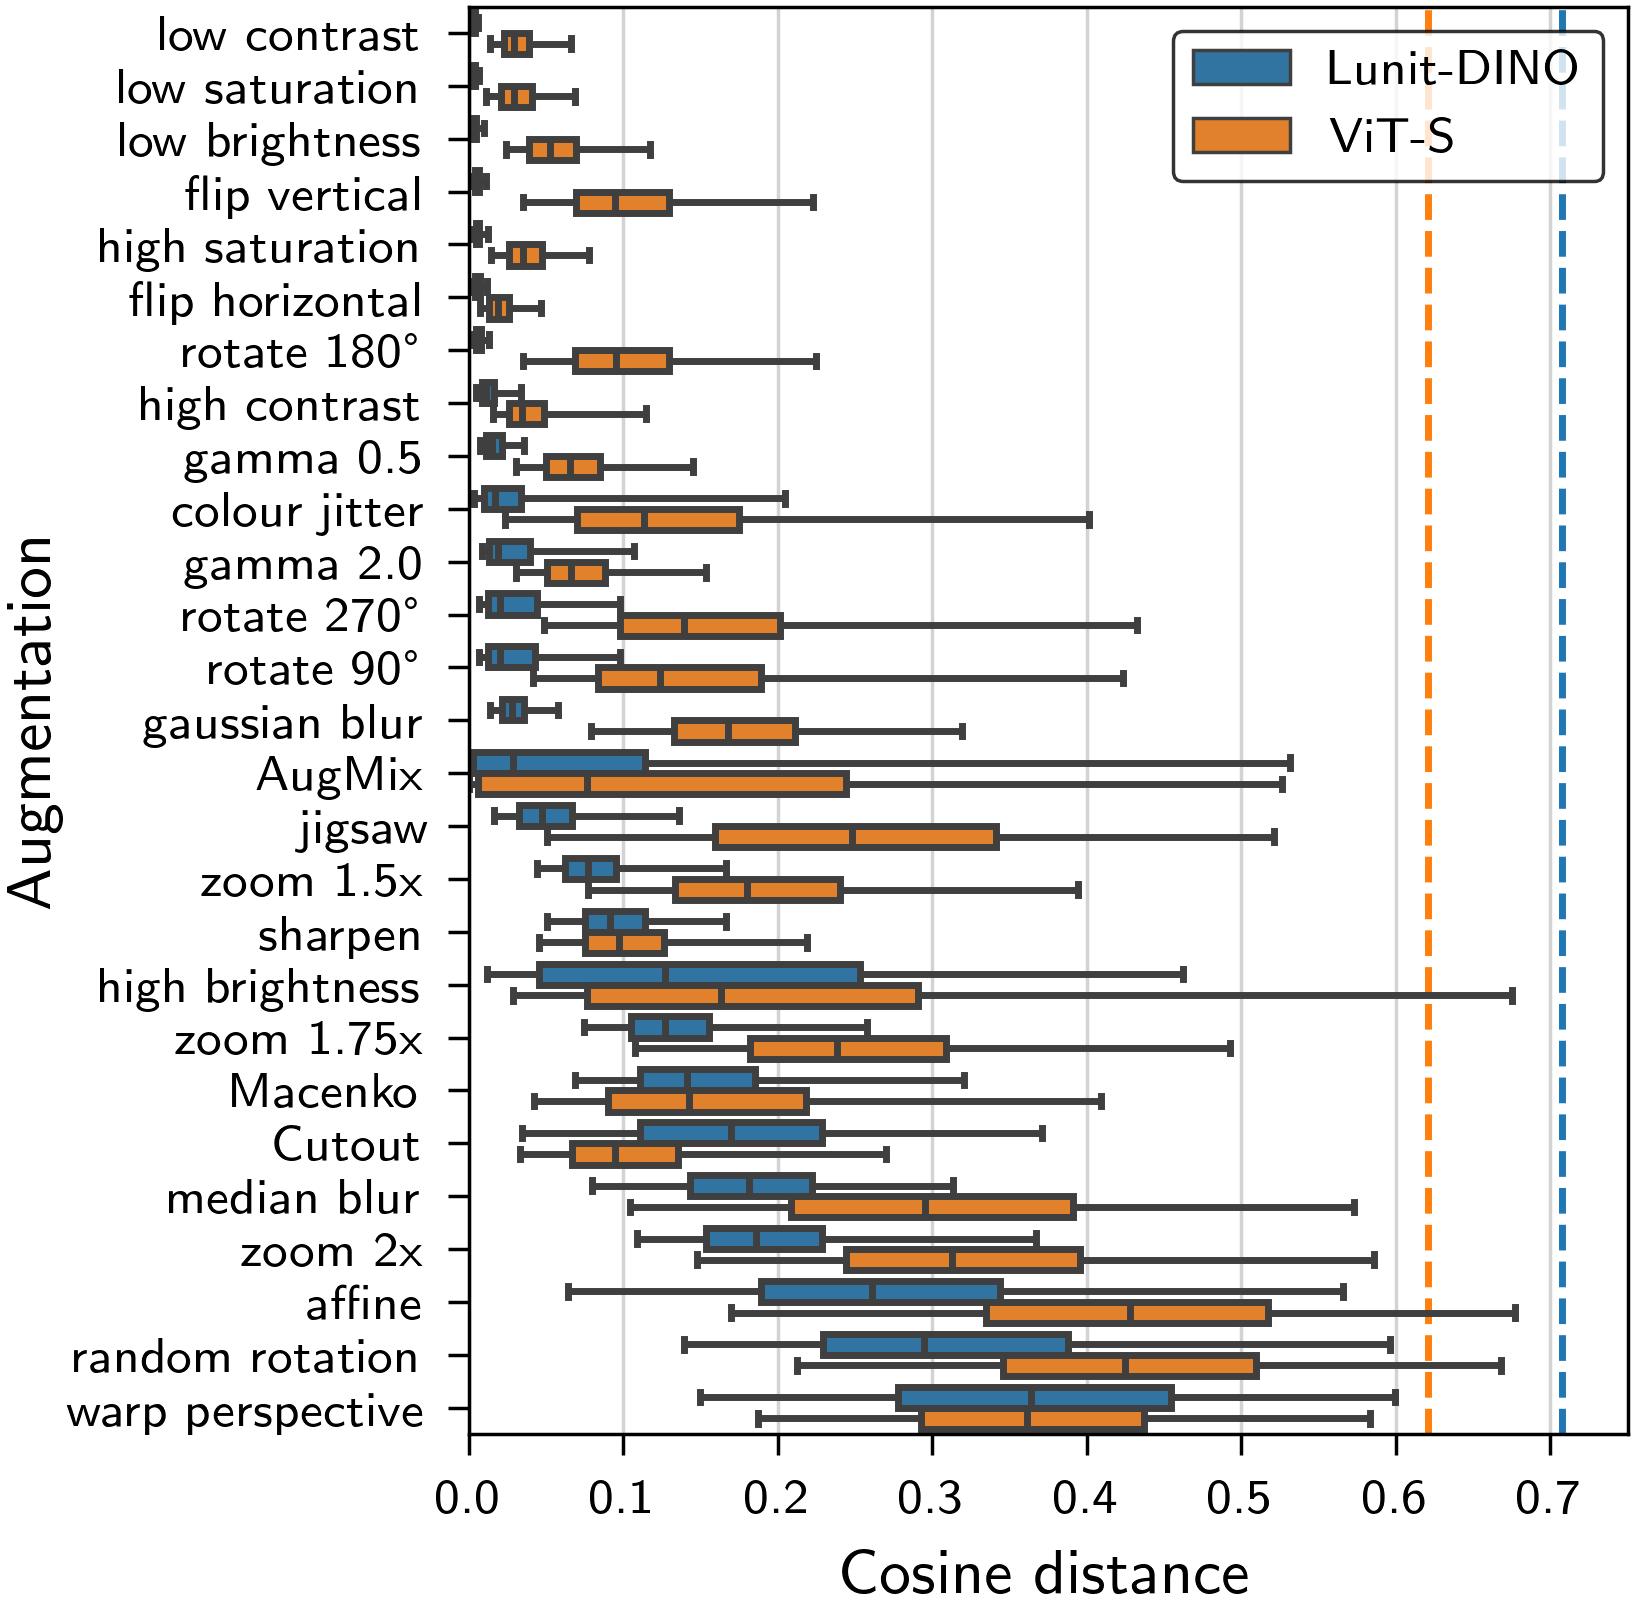

In [25]:
import seaborn as sns
from tueplots import figsizes, fontsizes, fonts, bundles, axes
from histaug.utils.display import RENAME_FEATURE_EXTRACTORS

with plt.rc_context(
    {
        **axes.lines(),
        **bundles.tmlr2023(family="sans-serif"),
        **figsizes.cvpr2022_half(height_to_width_ratio=1.0),
        "figure.dpi": 500,
    }
):
    plt.figure()
    d = df.query("augmentation != 'rotate random angle and zoom 1.5x'").copy()
    d["Feature extractor"] = d["model"].map(RENAME_FEATURE_EXTRACTORS)
    d["augmentation"] = d["augmentation"].map(lambda x: RENAME_AUGMENTATIONS.get(x, x))

    # Plot baseline similarity
    for (model, baseline_similarity), color in zip(baseline_similarity_by_model.items(), sns.color_palette()):
        plt.axvline(
            baseline_similarity,
            color=color,
            linestyle="--",  # label=f"{RENAME_FEATURE_EXTRACTORS[model]} baseline"
        )

    # Boxplot
    sns.boxplot(
        data=d,
        y="augmentation",
        x="dist",
        hue="Feature extractor",
        hue_order=[RENAME_FEATURE_EXTRACTORS[m] for m in models],
        showfliers=False,
        whis=[2.5, 97.5],
        order=d.query("model == 'dino_p16'").groupby("augmentation")["dist"].median().sort_values(ascending=True).index,
        ax=plt.gca(),
    )
    plt.xlabel("Cosine distance")
    plt.ylabel("Augmentation")

    # Y label should not be rotated; it should be on the right side; it should be above the ticks
    # plt.gca().yaxis.tick_right()
    # plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.set_label_coords(-0.35, 0.5)

    # light grey vertical tick lines
    plt.gca().grid(axis="x", color="lightgrey")

    plt.legend(loc="upper right")
    plt.xlim(0.0, 0.75)
    plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

    plt.show()